# Sistema de Recomendação
## Baseado em Matrix Factorization SVD

Autores: Andrei Donati, Angelo Baruffi e Luís Felipe Pelison

O DataSet utilizado para este código é o MovieLens (https://grouplens.org/datasets/movielens/). 
A fim de teste, foi adicionado entradas referentes ao desenvolvedor. 

# Bibliotecas python (3)

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
%matplotlib inline
#import os
#os.chdir('c:\\Andrei\\recommender-systems\\dataset')

# Importação dos dados

## Ratings

In [222]:
ratings_df = pd.read_csv("./dataset/ratings.csv", sep=",")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Temos o id do usuário (*userId*), do filme (*movieId*), a nota dada pelo usuário ao filme (*rating*) e o horário que essa nota foi dada (*timestamp*)

Porém, não precisaremos do horário aqui, então vamos excluir a coluna *timestamp*

In [223]:
ratings_df = ratings_df.iloc[:,0:3]
ratings_df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### Separação em teste e treino

In [224]:
## Vamos separar os dados em 2 conjuntos: teste e treino
ratings_df, ratings_df_test = train_test_split(
                                ratings_df, test_size=0.05, random_state=42)

## Visualizando a quantidade de dados de cada conjunto
ratings_df_test.shape[0], ratings_df.shape[0]

(5001, 95003)

## Movies

In [225]:
movies_df = pd.read_csv("./dataset/movies.csv", sep=",")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [226]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9125 non-null int64
title      9125 non-null object
genres     9125 non-null object
dtypes: int64(1), object(2)
memory usage: 213.9+ KB


# Adicionando dados pessoais

In [227]:
#Quantos usuários existem?

num_users  = np.max(ratings_df['userId']) +1
print("Number of users {}".format(num_users))

Number of users 672


Adicionando os meus dados

In [228]:
##Agora, vou criar um novo usuário, de id 672 (O próximo da lista)
##A classificação do novo usuário será uma tabela onde a primeira coluna é o id 672, a segunda é o id do filme 
## e a terceira a nota. > [userId, movieId, rating]

my_ratings= pd.DataFrame([[672, 1, 3.5 ], [672, 135861, 4.5], [672, 133824, 1], [672, 130634, 5], 
                          [672, 116797, 4.5], [672, 114662, 4], [672, 112897, 4], [672, 112497, 2],
                          [672, 112370, 3.5], [672, 112183, 5], [672, 110553, 3.5], [672, 109673, 4.5],
                          [672, 108932, 1], [672, 50189, 4], [672, 59784, 3.5], [672, 61123, 1], 
                          [672, 61160, 2], [672, 62999, 4], [672, 63515, 4.5], [672, 67923, 4.5],
                          [672, 68157, 5]], columns=['userId','movieId','rating']
                        ) 

print('Visualizando os filmes que gosto')
## Join das minhas avaliações com o título do filme e os gêneros, somente para visualização
my_ratings.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').sort_values(by=['rating'], ascending=False).head(10)

Visualizando os filmes que gosto


,userId,movieId,rating,title,genres
20,672,68157,5.0,Inglourious Basterds (2009),Action|Drama|War
3,672,130634,5.0,Furious 7 (2015),Action|Crime|Thriller
9,672,112183,5.0,Birdman: Or (The Unexpected Virtue of Ignoranc...,Comedy|Drama
19,672,67923,4.5,"Fast & Furious (Fast and the Furious 4, The) (...",Action|Crime|Drama|Thriller
4,672,116797,4.5,The Imitation Game (2014),Drama|Thriller|War
18,672,63515,4.5,The Island (2006),Drama|Mystery
1,672,135861,4.5,Ted 2 (2015),Comedy
11,672,109673,4.5,300: Rise of an Empire (2014),Action|Drama|War|IMAX
13,672,50189,4.0,American Pie Presents The Naked Mile (American...,Comedy|Romance
5,672,114662,4.0,American Sniper (2014),Action|War


In [229]:
my_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
userId     21 non-null int64
movieId    21 non-null int64
rating     21 non-null float64
dtypes: float64(1), int64(2)
memory usage: 584.0 bytes


Une os datasets

In [230]:
ratings_df = ratings_df.append(my_ratings)
ratings_df[ratings_df['userId'] == 672]

,userId,movieId,rating
0,672,1,3.5
1,672,135861,4.5
2,672,133824,1.0
3,672,130634,5.0
4,672,116797,4.5
5,672,114662,4.0
6,672,112897,4.0
7,672,112497,2.0
8,672,112370,3.5
9,672,112183,5.0


## Matriz de Users x Filmes, com os valores das notas dadas

In [231]:
R_df = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
R_df[-5:]

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
671,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualização de algumas informações importantes

Entradas não nulas da matriz

In [232]:
print('% entradas não nulas: {:0.4f} %'.format(100*(np.count_nonzero(R_df>0.0)/(R_df.shape[0]*R_df.shape[1]))) )

% entradas não nulas: 1.5872 %


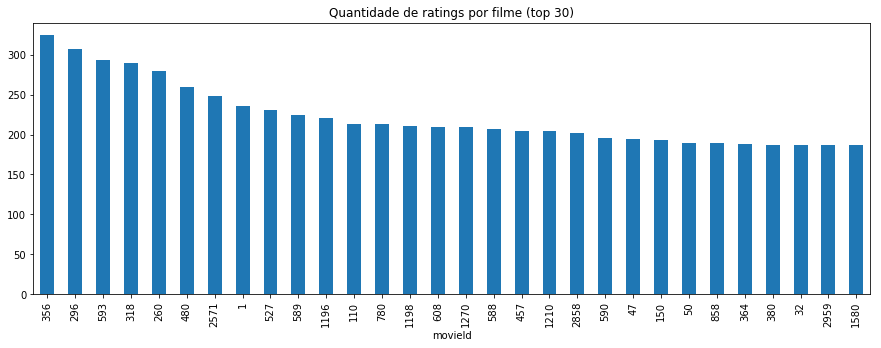

In [233]:
R_df[R_df>0.0].count(axis = 0).sort_values(ascending= False)[:30].plot(figsize=(15,5), kind='bar', title='Quantidade de ratings por filme (top 30)');

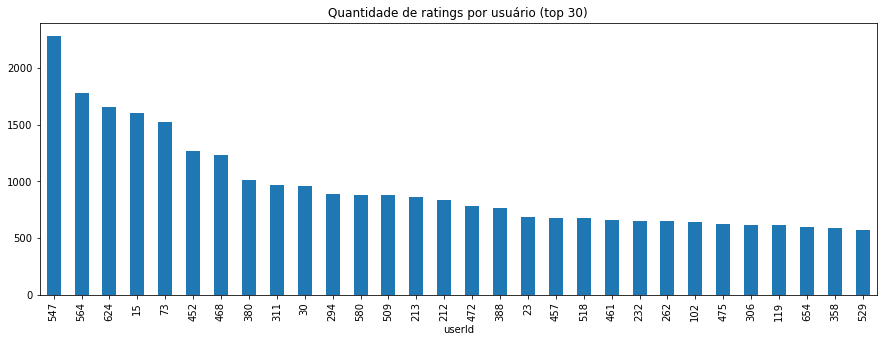

In [234]:
R_df[R_df>0.0].count(axis = 1).sort_values(ascending= False)[:30].plot(figsize=(15,5), kind='bar', title='Quantidade de ratings por usuário (top 30)');

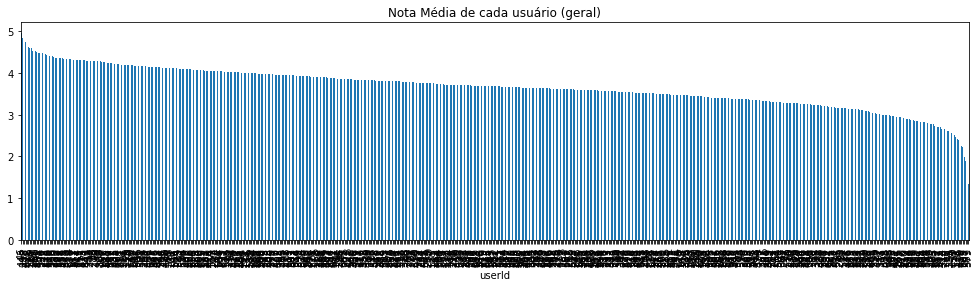

In [235]:
R_df[R_df>0.0].mean(axis = 1).sort_values(ascending= False).plot(figsize=(17,4), kind='bar', title='Nota Média de cada usuário (geral)');

# Modelo: Algoritmo SVD

Substitui os valores nulos por 0 e transforma a matriz de reviews em uma matriz com uma diferença da média do usuário


In [236]:
R = R_df.as_matrix()
R.shape, R

((672, 8909), array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        ..., 
        [ 4. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 5. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 3.5,  0. ,  0. , ...,  0. ,  0. ,  0. ]]))

In [237]:
user_ratings_mean = np.mean(R, axis=1)
user_ratings_mean, user_ratings_mean.shape

(array([ 0.00572455,  0.02895948,  0.01863284,  0.09529689,  0.0433831 ,
         0.01498485,  0.03187788,  0.04669435,  0.01896958,  0.01784712,
         0.01616343,  0.01616343,  0.02042878,  0.00639802,  0.46980581,
         0.01245931,  0.14249635,  0.01818386,  0.16006286,  0.03490852,
         0.06162308,  0.0787406 ,  0.27982939,  0.00864295,  0.00886744,
         0.06291391,  0.00931642,  0.02357167,  0.00645415,  0.40649905,
         0.03086766,  0.0170614 ,  0.04669435,  0.07890897,  0.00510719,
         0.0411943 ,  0.01425525,  0.0509597 ,  0.02491862,  0.02020429,
         0.08418453,  0.02845437,  0.03546975,  0.00909193,  0.00847458,
         0.01784712,  0.0156022 ,  0.1928387 ,  0.03479627,  0.01694915,
         0.01335728,  0.0268268 ,  0.01436749,  0.01762263,  0.014143  ,
         0.20069593,  0.08934785,  0.0270513 ,  0.02643394,  0.02441351,
         0.05926591,  0.02312268,  0.03816365,  0.00897968,  0.01156134,
         0.02155124,  0.04040858,  0.04703109,  0.0

In [238]:
R_demeaned = R - user_ratings_mean.reshape(-1, 1)
R_demeaned, R_demeaned.shape

(array([[-0.00572455, -0.00572455, -0.00572455, ..., -0.00572455,
         -0.00572455, -0.00572455],
        [-0.02895948, -0.02895948, -0.02895948, ..., -0.02895948,
         -0.02895948, -0.02895948],
        [-0.01863284, -0.01863284, -0.01863284, ..., -0.01863284,
         -0.01863284, -0.01863284],
        ..., 
        [ 3.98709171, -0.01290829, -0.01290829, ..., -0.01290829,
         -0.01290829, -0.01290829],
        [ 4.95139746, -0.04860254, -0.04860254, ..., -0.04860254,
         -0.04860254, -0.04860254],
        [ 3.49163767, -0.00836233, -0.00836233, ..., -0.00836233,
         -0.00836233, -0.00836233]]), (672, 8909))

### Aplica a transformação SVD

In [239]:
U, sigma, Vt = svds(R_demeaned, k = 80)

sigma = np.diag(sigma)

#### Reconstroi a matrix de ratings

In [240]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings = all_user_predicted_ratings + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df[-5:]

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
667,0.523202,-0.207267,-0.188100,-0.038132,-0.151641,0.065063,-0.158715,-0.064674,-0.059562,-0.147283,...,0.001405,0.000745,0.001249,0.004030,0.005581,-0.005829,0.001409,-0.004255,-0.002181,0.001881
668,0.633334,-0.174872,0.273468,0.010332,-0.035582,0.257017,0.070778,0.015411,0.231517,-0.087814,...,-0.002709,-0.002255,-0.001285,-0.003510,-0.004072,-0.071177,-0.000734,-0.001034,-0.001575,-0.003031
669,1.717892,0.037459,-0.178518,-0.070181,0.177966,0.761324,0.080675,-0.070936,-0.080624,0.055610,...,0.007281,0.003340,0.012009,0.009551,0.012495,0.007812,0.016183,-0.001616,0.000495,0.010901
670,3.513651,0.241106,-0.378422,0.195809,-0.024433,0.138251,-0.132892,0.095707,-0.326952,0.252027,...,-0.003441,-0.001327,-0.000554,0.008081,0.009109,-0.035885,-0.003844,0.022771,0.016073,-0.012907
671,0.822432,0.054845,0.075129,0.020628,-0.000119,0.063715,0.056426,0.020627,0.048006,-0.018953,...,0.003964,0.006757,0.015631,0.009840,0.011536,-0.001876,0.020223,0.009915,0.008527,0.001481


In [241]:
del U, sigma, Vt,  R, user_ratings_mean, all_user_predicted_ratings

Define alguns parâmetros

In [242]:
userId= 672
num_recommendations= 10

#### Filtra os filmes já assistidos

In [243]:
user_row_number = userId - 1 

#pega as filmes que o usuário já assistiu
sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) 
    
user_data = ratings_df[ratings_df['userId'] == (userId)]
already_rated = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                sort_values(['rating'], ascending=False)
            )

print('Usuário {0} já deixou seu rating para {1} filmes.'.format(userId, already_rated.shape[0]) )
  

Usuário 672 já deixou seu rating para 21 filmes.


# Recomendações

In [244]:
predictions = (movies_df[~movies_df['movieId'].isin(already_rated['movieId'])].
                     merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
                   left_on = 'movieId', right_on = 'movieId').
                   rename(columns = {user_row_number: 'Predictions'}).
                   sort_values('Predictions', ascending = False).
                   iloc[:num_recommendations, :-1]
                  )

print('Recomendando os top {0} filmes ainda não vistos pelo usuário.'.format(num_recommendations))

Recomendando os top 10 filmes ainda não vistos pelo usuário.


In [245]:
predictions

,movieId,title,genres
2505,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
8764,122882,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller
320,356,Forrest Gump (1994),Comedy|Drama|Romance|War
3804,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
8217,99114,Django Unchained (2012),Action|Drama|Western
7566,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
8526,109487,Interstellar (2014),Sci-Fi|IMAX
7547,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
7227,68954,Up (2009),Adventure|Animation|Children|Drama
231,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


## Comparando
### com os filmes que melhor foram avaliados por mim:

In [246]:
already_rated

,userId,movieId,rating,title,genres
20,672,68157,5.0,Inglourious Basterds (2009),Action|Drama|War
3,672,130634,5.0,Furious 7 (2015),Action|Crime|Thriller
9,672,112183,5.0,Birdman: Or (The Unexpected Virtue of Ignoranc...,Comedy|Drama
19,672,67923,4.5,"Fast & Furious (Fast and the Furious 4, The) (...",Action|Crime|Drama|Thriller
4,672,116797,4.5,The Imitation Game (2014),Drama|Thriller|War
18,672,63515,4.5,The Island (2006),Drama|Mystery
1,672,135861,4.5,Ted 2 (2015),Comedy
11,672,109673,4.5,300: Rise of an Empire (2014),Action|Drama|War|IMAX
13,672,50189,4.0,American Pie Presents The Naked Mile (American...,Comedy|Romance
5,672,114662,4.0,American Sniper (2014),Action|War
